# Dense model | Pipeline version
You need to develop a short-term predictor. And you need to do it quickly.

<div class="alert alert-block alert-info">
<b>Problem Statement</b> 
    
Given Italian daily power load data from 2006 to day $t$, predict the load on day $t+1$.
</div>

Your first idea is an autoregressive model. You want to be flexible, so you opt for a dense neural network. By no means it is the state of the art, but as a first shot is will do.

<div class="alert alert-block alert-info">
<b>What's new in this notebook?</b> 
    
In this notebook, we will show how you can automate the data processing, model training, model saving and model deploying by using Sagemaker Pipelines.
</div>

# Setup
Again, you update the default packages in SageMaker studio.

Please, restart the kernel if this is the first time you run this notebook: it is necessary to ensure that we can actually import the libraries we've just installed in the previous cells.

In [1]:
# To read data from S3
! pip install pandas s3fs --upgrade

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
# 'ml.m4.xlarge' is included in the AWS Free Tier
# 'ml.m5.xlarge' is NOT included in the AWS Free Tier, and is used only for the sake of the workshop. YOU MIGHT ENCUR INTO COSTS IF YOU DECIDE TO USE THIS MACHINE.
INSTANCE_TYPE = 'ml.m4.xlarge'

In [3]:
import boto3
import sagemaker

import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# Data gathering
As in Fourier Regression.

In [4]:
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
sagemaker_client = boto_session.client("sagemaker")
sagemaker_bucket = sagemaker_session.default_bucket()
main_prefix = "amld22-workshop-sagemaker"

raw_data_s3_path = "s3://public-workshop/normalized_data/processed/2006_2022_data.parquet"
raw_df = pd.read_parquet(raw_data_s3_path)
resampled_df = raw_df.resample('D').sum()

You use as **training** set the data until the end of 2019, and as **test** set the data until the end of May 2020.   
To prepare the dataset for the neural network, you use a utility function to transform the load series into a dataframe of lagged features.   
Everything concerning the shaping of the data can be found in the `prepare_training_data.py` file, which is used during the processing step of the pipeline that we will be creating in this notebook.

# Pipeline preparation

Let us create an SKLearnProcessor, which we will be using within the pipeline.

In [5]:
from sagemaker.sklearn import SKLearnProcessor

JOB_NAME = "amld22workshop"

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type=INSTANCE_TYPE,
    instance_count=1,
    base_job_name=JOB_NAME,
    role=role
)

Then, we create a Processing step that takes in the raw .parquet data. This step will resample the data, create the lagged features and then store it into S3.

In [6]:
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ProcessingOutput, ProcessingInput

data_bucket_path = f's3://{sagemaker_bucket}/{main_prefix}/data'
output_train_path = f'{data_bucket_path}/train_data/train.parquet'
print(f"Raw data: {raw_data_s3_path}\nTraining output data: {output_train_path}")

prepare_data_step = ProcessingStep(
    name="GenerateTrainingData",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(
            source=raw_data_s3_path,
            destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train",
            destination=data_bucket_path,
            source="/opt/ml/processing/train"
        )
    ],
    code="prepare_training_data.py"
)

Raw data: s3://public-workshop/normalized_data/processed/2006_2022_data.parquet
Training output data: s3://sagemaker-eu-west-1-919788038405/amld22-workshop-sagemaker/data/train_data/train.parquet


Next, we start working on the model. First, we create the Tensorflow estimator using our Python training script.

In [7]:
from sagemaker.tensorflow import TensorFlow

# Hyperparameters
NUM_OF_EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

ff_estimator = TensorFlow(
    entry_point="dense_model_train.py",
    role=role,
    instance_count=1,
    instance_type=INSTANCE_TYPE,
    framework_version="2.4.1",
    py_version="py37",
    use_spot_instances = True,
    max_run = (30 * 60),
    max_wait = (50 * 60),
    hyperparameters={
        "num_of_epochs": NUM_OF_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "version_number": "0000001"
    }
)

After we have created our estimator, we build a **Training step** that - after the processing step is complete - takes the estimator and trains it on the output data.

In [8]:
from sagemaker.workflow.steps import TrainingStep

train_step = TrainingStep(
    name="TrainModel",
    depends_on=[prepare_data_step.name],
    estimator=ff_estimator,
    inputs={
        'training': output_train_path,
    },
)

Once we are done with the **Training Step**, a **RegisterModel Step** will register the model with the AWS model registry.

In [9]:
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.model import Model

image_uri = sagemaker.image_uris.retrieve(
        framework="tensorflow",
        region=region,
        version="2.4.1",
        image_scope="inference",
        instance_type=INSTANCE_TYPE
)

model = Model(
    image_uri=image_uri,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role,
)

step_register = RegisterModel(
    name="RegisterModel",
    model_package_group_name="covid-19-model",
    estimator=ff_estimator,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=[INSTANCE_TYPE],
    transform_instances=[INSTANCE_TYPE],
    approval_status='PendingManualApproval'
)

print(image_uri)

763104351884.dkr.ecr.eu-west-1.amazonaws.com/tensorflow-inference:2.4.1-cpu


Finally, we create a **CreateModel Step** to create the SageMaker model.

In [10]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.steps import CreateModelStep

step_create_model = CreateModelStep(
    name="CreateModel",
    model=model,
    inputs= CreateModelInput(
        instance_type=INSTANCE_TYPE,
    ),
)

The last thing we need is just packaging all the steps together and give a nice name to our pipeline.

In [11]:
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name='Dense-training-pipeline',
    steps=[
        prepare_data_step,
        train_step,
        step_register,
        step_create_model
    ]
)

Once the pipeline is packaged, running it is as easy as calling a `.create()` followed by a `.start()`

In [12]:
try:
    pipeline.create(role_arn=role)
except Exception as e:
    print(f"Exception: {repr(e)}")
    pipeline.update(role_arn=role)
    print("Pipeline already exists. Update and run!")

pipeline.start()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Exception: ClientError('An error occurred (ValidationException) when calling the CreatePipeline operation: Pipeline names must be unique within an AWS account and region. Pipeline with name (Dense-training-pipeline) already exists.')
Pipeline already exists. Update and run!


_PipelineExecution(arn='arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-training-pipeline/execution/s2tdw4m2usfq', sagemaker_session=<sagemaker.session.Session object at 0x7f64da3ce1d0>)

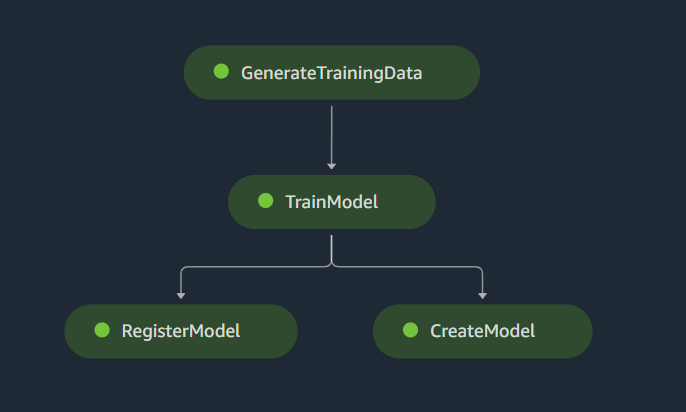

In [13]:
from IPython.display import Image
Image(filename='pipeline.png') 

# Now we need to deploy the model

first we need to fetch the model arn from the pipeline in order to create the model configuration

In [15]:
sg_client = boto3.client('sagemaker')

In [38]:
import time
time.sleep(10)

pipeline_executions = sg_client.list_pipeline_executions(
    PipelineName=pipeline.name,
    CreatedAfter=datetime.now()-timedelta(days=1),
    CreatedBefore=datetime.now(),
    SortBy='CreationTime',
    SortOrder='Descending'
)['PipelineExecutionSummaries']

for p in pipeline_executions:
    print(p)

pipeline_exec = pipeline_executions[0]['PipelineExecutionArn']
print(pipeline_exec)

{'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-training-pipeline/execution/s2tdw4m2usfq', 'StartTime': datetime.datetime(2022, 3, 26, 0, 23, 29, 92000, tzinfo=tzlocal()), 'PipelineExecutionStatus': 'Executing', 'PipelineExecutionDisplayName': 'execution-1648254209180'}
{'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-training-pipeline/execution/3obbklnu59nj', 'StartTime': datetime.datetime(2022, 3, 25, 14, 42, 30, 343000, tzinfo=tzlocal()), 'PipelineExecutionStatus': 'Succeeded', 'PipelineExecutionDisplayName': 'execution-1648219350430'}
{'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-training-pipeline/execution/9jjet1879e7e', 'StartTime': datetime.datetime(2022, 3, 25, 14, 27, 25, 929000, tzinfo=tzlocal()), 'PipelineExecutionStatus': 'Failed', 'PipelineExecutionDisplayName': 'execution-1648218445986'}
{'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-tr

In [39]:
pipeline_exec_desc = sg_client.describe_pipeline_execution(
    PipelineExecutionArn=pipeline_exec
)
pipeline_exec_desc

{'PipelineArn': 'arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-training-pipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-1:919788038405:pipeline/dense-training-pipeline/execution/s2tdw4m2usfq',
 'PipelineExecutionDisplayName': 'execution-1648254209180',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'dense-training-pipeline',
  'TrialName': 's2tdw4m2usfq'},
 'CreationTime': datetime.datetime(2022, 3, 26, 0, 23, 29, 92000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 3, 26, 0, 23, 29, 92000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:eu-west-1:919788038405:user-profile/d-964i8zo7pyh7/default-1648040213244',
  'UserProfileName': 'default-1648040213244',
  'DomainId': 'd-964i8zo7pyh7'},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:eu-west-1:919788038405:user-profile/d-964i8zo7pyh7/default-1648040213244',
  'UserProfileName': 'default-1648040213244',
  'DomainId': 'd

In [43]:
steps = sg_client.list_pipeline_execution_steps(
    PipelineExecutionArn=pipeline_exec,
    SortOrder='Descending'
)['PipelineExecutionSteps']
steps

[{'StepName': 'TrainModel',
  'StartTime': datetime.datetime(2022, 3, 26, 0, 28, 41, 480000, tzinfo=tzlocal()),
  'StepStatus': 'Executing',
  'AttemptCount': 0,
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:eu-west-1:919788038405:training-job/pipelines-s2tdw4m2usfq-trainmodel-w0ear3kzkm'}}},
 {'StepName': 'GenerateTrainingData',
  'StartTime': datetime.datetime(2022, 3, 26, 0, 23, 30, 54000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 3, 26, 0, 28, 40, 999000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 0,
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:eu-west-1:919788038405:processing-job/pipelines-s2tdw4m2usfq-generatetrainingdata-9yel4jorcw'}}}]

In [45]:
model_arn = None
for step in steps:
    if step['Metadata'].get('Model'):
        model_arn = step['Metadata']['Model']['Arn']
model_arn

## Create configuration for endpoint

In [20]:
from time import strftime, gmtime

epc_name = "covid19-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = sg_client.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_arn.split('/')[-1],
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ]
)
print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:eu-west-1:919788038405:endpoint-config/covid19-serverless-epc2022-03-26-00-23-29


## Deploy the model

In [30]:
endpoint_name = "covid19-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
create_endpoint_response = sg_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:eu-west-1:919788038405:endpoint/covid19-serverless-ep2022-03-26-00-25-46


In [22]:
predictor = sagemaker.predictor.Predictor(
    endpoint_name=endpoint_name, 
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

In [23]:
raw_data_s3_path = "s3://public-workshop/normalized_data/processed/2006_2022_data.parquet"
raw_df = pd.read_parquet(raw_data_s3_path)
resampled_df = raw_df.resample('D').sum()

In [24]:
data_df = resampled_df[:'2019-12-31 23:59'].copy()
covid_df = resampled_df[:'2020-05-31 23:59'].copy()

covid_len = covid_df.shape[0] - data_df.shape[0]

In [25]:
# To transform a series of datapoints into a dataframe that contains the lagged features
def build_lagged_df(series: pd.Series, n_lags: int) -> pd.DataFrame:
    df = pd.DataFrame({series.name: series})
    for i in range(1, n_lags + 1):
        df[f'{series.name}_{i}'] = series.shift(i)
    df = df.dropna()
    return df

In [31]:
n_lags = 7

# We rescale the dataset using the Max value within the training set
covid_max = data_df.Load.max()
dense_df = build_lagged_df(covid_df.Load / covid_max, n_lags=n_lags)

x_train_dense_scaled, x_test_dense_scaled, y_train_dense_scaled, y_test_dense_scaled = train_test_split(
    dense_df.drop(columns=['Load']),
    dense_df.Load,
    test_size=covid_len,
    shuffle=False
)

print(f"Train set length: {x_train_dense_scaled.shape[0]} | Test set length: {x_test_dense_scaled.shape[0]}")

train_df = dense_df.copy().loc[x_train_dense_scaled.index]
train_df.head()

Train set length: 5106 | Test set length: 152


,Load,Load_1,Load_2,Load_3,Load_4,Load_5,Load_6,Load_7
Date,,,,,,,,
2006-01-08,0.625919,0.668466,0.634970,0.780410,0.779691,0.769595,0.719701,0.560801
2006-01-09,0.833215,0.625919,0.668466,0.634970,0.780410,0.779691,0.769595,0.719701
2006-01-10,0.868690,0.833215,0.625919,0.668466,0.634970,0.780410,0.779691,0.769595
2006-01-11,0.877937,0.868690,0.833215,0.625919,0.668466,0.634970,0.780410,0.779691
2006-01-12,0.879426,0.877937,0.868690,0.833215,0.625919,0.668466,0.634970,0.780410


In [32]:
prediction = predictor.predict(x_test_dense_scaled.to_numpy())

In [33]:
y_pred = pd.Series([y[0] for y in prediction['predictions']], index=x_test_dense_scaled.index)

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_pred)

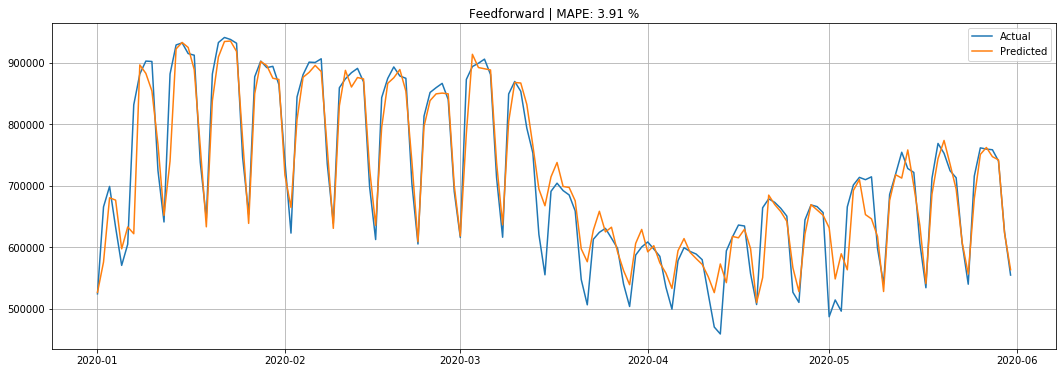

In [35]:
dense_mape = mean_absolute_percentage_error(y_test_dense_scaled * covid_max, y_pred * covid_max)

plt.figure(figsize=(18, 6))
plt.title(f"Feedforward | MAPE: {100 * dense_mape:.2f} %")
plt.plot(y_test_dense_scaled * covid_max, label='Actual')
plt.plot(y_pred * covid_max, label='Predicted')
plt.legend()
plt.grid(0.4)
plt.show()